In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import auc,roc_curve,precision_recall_fscore_support
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

The data is weather data for New York city. TRaining data is from Oct 2012 to Dec 2015. Validation data is from Jan 2016 to 
Dec 2016

In [2]:
train = pd.read_csv('train_weather_nyc.csv',index_col='Date',parse_dates=True) # pandas dataframe
val = pd.read_csv('val_weather_nyc.csv',index_col='Date',parse_dates=True)

In [5]:
train.tail(5)

,humidity,pressure,temperature,wind_direction,wind_speed,rain_prob,label
Date,,,,,,,
2015-12-27,85.000000,1018.458333,283.769449,172.333333,3.208333,0.343750,1
2015-12-28,60.083333,1025.291667,278.963545,206.750000,4.500000,0.375000,1
2015-12-29,85.291667,1022.708333,276.262428,108.416667,5.083333,0.354167,1
2015-12-30,88.916667,1023.458333,277.663850,92.458333,1.666667,0.354167,1
2015-12-31,82.708333,1018.708333,280.300591,248.541667,2.750000,0.427083,1


In [7]:
val.tail() # default = 5

,humidity,pressure,temperature,wind_direction,wind_speed,rain_prob,label
Date,,,,,,,
2016-12-27,76.958333,1014.458333,283.730000,246.125000,4.791667,0.281250,1
2016-12-28,56.791667,1017.458333,277.164583,296.833333,2.625000,0.125000,0
2016-12-29,77.500000,1012.791667,274.462917,212.916667,2.708333,0.031250,1
2016-12-30,64.000000,1003.416667,275.349167,277.291667,4.833333,0.010417,0
2016-12-31,62.958333,1017.125000,274.341667,243.458333,3.750000,0.010417,0


Next, we need to decide the number of previous days we need for predicting rain on a given day. 

<img src = "rain_labels.png">

In [12]:
train.describe()

,humidity,pressure,temperature,wind_direction,wind_speed,rain_prob,label
count,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000
mean,67.326984,1016.829403,284.636947,199.382194,3.199010,0.168303,0.581297
std,14.295169,9.886293,9.876013,74.206606,1.671223,0.209258,0.493554
min,28.416667,974.833333,259.019750,22.708333,0.444444,0.000000,0.000000
25%,57.648810,1012.125000,276.963626,147.500000,2.000000,0.010417,0.000000
50%,68.208333,1017.166667,285.377575,211.625000,2.833333,0.093750,1.000000
75%,78.312500,1022.697917,293.563396,254.107955,3.958333,0.250000,1.000000
max,98.583333,1049.625000,304.698333,341.791667,12.375000,1.000000,1.000000


In [8]:
win = 2  # number of previous days' data to use
dim = train.shape[1] - 1 # number of features per day

6

In [9]:
# Training dataset

xy = train.values # raw values as numpy array
x = xy[:,:dim] # 6 columns
y = xy[:,dim] # label column

x_train = np.array([])
y_train = np.zeros(x.shape[0] - win)

for i in range(0,x.shape[0] - win):
    tr_x = x[i:i+win,:].ravel()  # convert into 1-D array (0:2,1:3,2:4,3:5...)
    tr_y = y[i+win] # next day weather (2,3,4,5,...)
    if not x_train.size:
        x_train = tr_x[np.newaxis,...]
        
    else:
        x_train = np.r_[x_train,tr_x[np.newaxis,...]]
    y_train[i] = tr_y
    

In [10]:
# Validation dataset

xy = val.values
x = xy[:,:dim]
y = xy[:,dim]

x_val = np.array([])
y_val = np.zeros(x.shape[0] - win)

for i in range(0,x.shape[0] - win):
    tr_x = x[i:i+win,:].ravel() # convert into 1-D array
    tr_y = y[i+win] # next day weather
    if not x_val.size:
        x_val = tr_x[np.newaxis,...]
        
    else:
        x_val = np.r_[x_val,tr_x[np.newaxis,...]]
    y_val[i] = tr_y
    

In [11]:
x_train.shape

(1185, 12)

In [13]:
x_val.shape

(364, 12)

In [14]:
y_train.shape

(1185,)

# Decision Tree model

In [15]:
dt_mdl = DecisionTreeClassifier().fit(x_train,y_train)

In [16]:
score = dt_mdl.predict_proba(x_train) # gives probability score for each class [no-rain, rain]
score
# [0.38, 0.62]  --> 68% prob that example belongs to class 1 and 38% prob that example belongs to class 0 marginally confident
# [0.49, 0.51]  --> 51% prob that example belongs to class 1 and 49% prob that example belongs to class 0 not confident
# [0.01, 0.99]  --> 99% prob that example belongs to class 1 and 1% prob that example belongs to class 0  HF

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [18]:
pred = dt_mdl.predict(x_train) # directly gives you class label predictions
pred

array([1., 1., 1., ..., 1., 1., 1.])

Training data
-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       495
         1.0       1.00      1.00      1.00       690

    accuracy                           1.00      1185
   macro avg       1.00      1.00      1.00      1185
weighted avg       1.00      1.00      1.00      1185

PPV:	1.0
Se:	1.0
FSc:	1.0

Validation data
---------------
              precision    recall  f1-score   support

         0.0       0.55      0.58      0.57       140
         1.0       0.73      0.71      0.72       224

    accuracy                           0.66       364
   macro avg       0.64      0.64      0.64       364
weighted avg       0.66      0.66      0.66       364

PPV:	0.7293577981651376
Se:	0.7098214285714286
FSc:	0.7194570135746606


Text(0.5, 1.0, 'Validation')

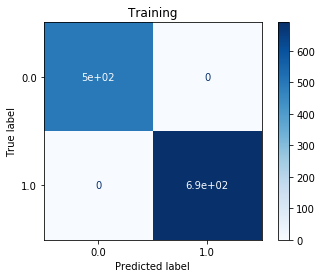

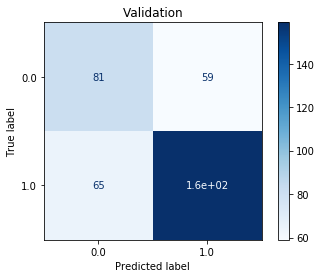

In [22]:

thr = 0.5
print('Training data')
print('-------------')
y_score0 = dt_mdl.predict_proba(x_train)  #probability scores
y_pred0 = np.zeros(x_train.shape[0])
y_pred0[np.where(y_score0[:,1] >= thr)[0]] = 1

print(classification_report(y_train,y_pred0))
metrics = ['PPV','Se','FSc']
for i,j in zip(metrics,precision_recall_fscore_support(y_train,y_pred0,average='binary')[:3]):
    print('{}:\t{}'.format(i,j))
    

p1 = plot_confusion_matrix(dt_mdl, x_train, y_train,
                                 
                                 cmap=plt.cm.Blues,
                                 )
p1.ax_.set_title('Training')  
    
print()
print('Validation data')
print('---------------')

y_scorev = dt_mdl.predict_proba(x_val)
y_predv = np.zeros(x_val.shape[0])
y_predv[np.where(y_scorev[:,1] >= thr)[0]] = 1


print(classification_report(y_val,y_predv))
metrics = ['PPV','Se','FSc']
for i,j in zip(metrics,precision_recall_fscore_support(y_val,y_predv,average='binary')[:3]):
    print('{}:\t{}'.format(i,j))
    

p2 = plot_confusion_matrix(dt_mdl, x_val, y_val,
                                 
                                 cmap=plt.cm.Blues,
                                 )
p2.ax_.set_title('Validation')  


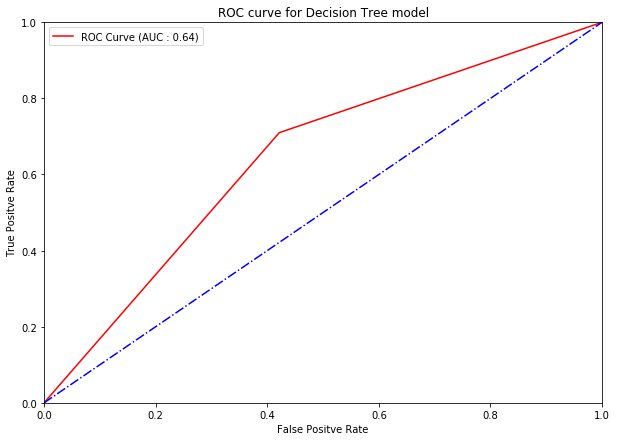

In [23]:
# Computing AUC and ROC curve for logistic regression model on validation data

# fp_rate_lr  : false positive rate for Logistic Regression model
# tp_rate_lr  : true positive rate for Logistic Regression model
# auc_rate_lr : AUC for Logistic Regression model

fp_rate_lr,tp_rate_lr,_ = roc_curve(y_val,y_scorev[:,1]) # column 1 meets criteria where prob >= 0.5 corresponds to class-1
auc_val_lr = auc(fp_rate_lr,tp_rate_lr)

plt.figure(figsize=(10,7))
plt.plot(fp_rate_lr,tp_rate_lr,label='ROC Curve (AUC : {:.2f})'.format(auc_val_lr),color='red')
plt.plot([0, 1], [0, 1], color='blue', linestyle='-.')
plt.title('ROC curve for Decision Tree model')
plt.xlabel('False Positve Rate')
plt.ylabel('True Positve Rate')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.legend()
plt.show()

# Random Forests

In [24]:
rf_mdl = RandomForestClassifier(random_state=np.random.seed(5)).fit(x_train,y_train)

Training data
-------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       495
         1.0       1.00      1.00      1.00       690

    accuracy                           1.00      1185
   macro avg       1.00      1.00      1.00      1185
weighted avg       1.00      1.00      1.00      1185

PPV:	1.0
Se:	1.0
FSc:	1.0

Validation data
-------------
              precision    recall  f1-score   support

         0.0       0.61      0.54      0.57       140
         1.0       0.73      0.78      0.76       224

    accuracy                           0.69       364
   macro avg       0.67      0.66      0.66       364
weighted avg       0.68      0.69      0.69       364

PPV:	0.7322175732217573
Se:	0.78125
FSc:	0.755939524838013


Text(0.5, 1.0, 'Validation')

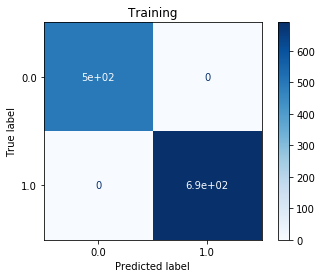

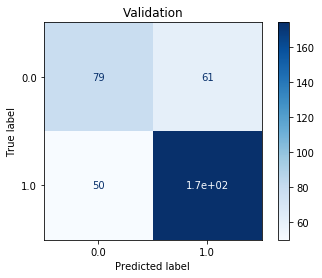

In [25]:
thr = 0.5
print('Training data')
print('-------------')

y_score0 = rf_mdl.predict_proba(x_train)
y_pred0 = np.zeros(x_train.shape[0])
y_pred0[np.where(y_score0[:,1] >= thr)[0]] = 1


print(classification_report(y_train,y_pred0))
metrics = ['PPV','Se','FSc']
for i,j in zip(metrics,precision_recall_fscore_support(y_train,y_pred0,average='binary')[:3]):
    print('{}:\t{}'.format(i,j))

    
p1 = plot_confusion_matrix(rf_mdl, x_train, y_train,
                                 
                                 cmap=plt.cm.Blues,
                                 )
p1.ax_.set_title('Training')    
print()
print('Validation data')
print('-------------')

y_scorev = rf_mdl.predict_proba(x_val)
y_predv = np.zeros(x_val.shape[0])
y_predv[np.where(y_scorev[:,1] >= thr)[0]] = 1


print(classification_report(y_val,y_predv))
metrics = ['PPV','Se','FSc']
for i,j in zip(metrics,precision_recall_fscore_support(y_val,y_predv,average='binary')[:3]):
    print('{}:\t{}'.format(i,j))


        
p2 = plot_confusion_matrix(rf_mdl, x_val, y_val,
                                 
                                 cmap=plt.cm.Blues,
                                 )

p2.ax_.set_title('Validation') 

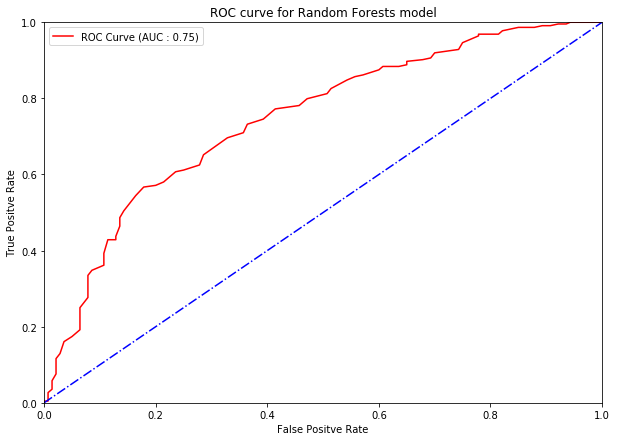

In [26]:
# Computing AUC and ROC curve for logistic regression model on validation data

# fp_rate_lr  : false positive rate for Logistic Regression model
# tp_rate_lr  : true positive rate for Logistic Regression model
# auc_rate_lr : AUC for Logistic Regression model

fp_rate_lr,tp_rate_lr,_ = roc_curve(y_val,y_scorev[:,1]) # column 1 meets criteria where prob >= 0.5 corresponds to class-1
auc_val_lr = auc(fp_rate_lr,tp_rate_lr)

plt.figure(figsize=(10,7))
plt.plot(fp_rate_lr,tp_rate_lr,label='ROC Curve (AUC : {:.2f})'.format(auc_val_lr),color='red')
plt.plot([0, 1], [0, 1], color='blue', linestyle='-.')
plt.title('ROC curve for Random Forests model')
plt.xlabel('False Positve Rate')
plt.ylabel('True Positve Rate')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.legend()
plt.show()

In [39]:
# Hyperparameters for Random Forests model

no_feat = x_train.shape[1]  # number of features in the input

learn_alg = RandomForestClassifier()
# Search space

num_trees = [int(i) for i in range(10,100,5)]   # number of trees   [10,15,20,25..100]
class_wt = ['balanced']  # class weight
min_samples_leaf = [int(i) for i in np.arange(start=1,stop=20,step=5)] #   [1,6,11,16]
max_depth = [int(i) for i in np.arange(start=1,stop=25,step=2)] # maximum depth of tree  [1,3,5,7,11,...]
                                                                # (low values generally help reduce overfitting)
max_depth.append(None)

mdl_params = {'n_estimators': num_trees,
               'class_weight': class_wt,
               'min_samples_leaf':min_samples_leaf,
               'max_depth': max_depth,

                }
# dict ->{key:value}

In [40]:
print(len(num_trees))
print(len(class_wt))
print(len(min_samples_leaf))
print(len(max_depth))

18
1
4
13


In [41]:
a = []
for i in range(5):
    for j in range(5):
        a.append(i+j)
print(a)

[0, 1, 2, 3, 4, 1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]


In [42]:
a = [(i+j) for i in range(5) for j in range(5)]  #list comprehension
print(a)

[0, 1, 2, 3, 4, 1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]


In [43]:
# Grid Search

rf_mdls = GridSearchCV(estimator=learn_alg,param_grid=mdl_params,scoring='f1',cv=5,n_jobs=-1,verbose=2) #use all cores
rf_mdls.fit(x_train,y_train)

print('Best model from training set:')
print()
print(rf_mdls.best_params_)
print()
    

Fitting 5 folds for each of 936 candidates, totalling 4680 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 4680 out of 4680 | elapsed:  3.5min finished


Best model from training set:

{'class_weight': 'balanced', 'max_depth': 13, 'min_samples_leaf': 1, 'n_estimators': 60}



Training data
-------------
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       495
         1.0       1.00      1.00      1.00       690

    accuracy                           1.00      1185
   macro avg       1.00      1.00      1.00      1185
weighted avg       1.00      1.00      1.00      1185

PPV:	0.9956709956709957
Se:	1.0
FSc:	0.9978308026030369

Validation data
---------------
              precision    recall  f1-score   support

         0.0       0.61      0.55      0.58       140
         1.0       0.73      0.78      0.75       224

    accuracy                           0.69       364
   macro avg       0.67      0.66      0.67       364
weighted avg       0.68      0.69      0.69       364

PPV:	0.7341772151898734
Se:	0.7767857142857143
FSc:	0.754880694143167


Text(0.5, 1.0, 'Validation')

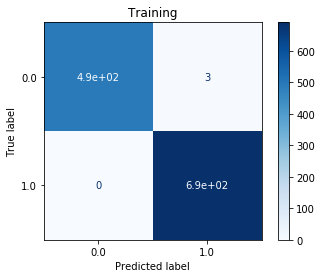

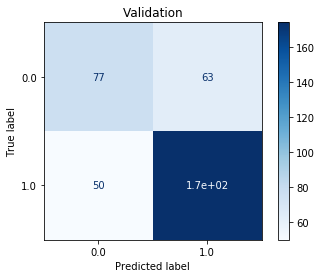

In [44]:
best_model = rf_mdls.best_estimator_ # get the best estimator from Grid Search models

thr = 0.5
print('Training data')
print('-------------')
y_score0 = best_model.predict_proba(x_train)
y_pred0 = np.zeros(x_train.shape[0])
y_pred0[np.where(y_score0[:,1] >= thr)[0]] = 1

print(classification_report(y_train,y_pred0))
metrics = ['PPV','Se','FSc']
for i,j in zip(metrics,precision_recall_fscore_support(y_train,y_pred0,average='binary')[:3]):
    print('{}:\t{}'.format(i,j))
    

p1 = plot_confusion_matrix(best_model, x_train, y_train,
                                 
                                 cmap=plt.cm.Blues,
                                 )
p1.ax_.set_title('Training')  
    
print()
print('Validation data')
print('---------------')

y_scorev = best_model.predict_proba(x_val)
y_predv = np.zeros(x_val.shape[0])
y_predv[np.where(y_scorev[:,1] >= thr)[0]] = 1


print(classification_report(y_val,y_predv))
metrics = ['PPV','Se','FSc']
for i,j in zip(metrics,precision_recall_fscore_support(y_val,y_predv,average='binary')[:3]):
    print('{}:\t{}'.format(i,j))
    

p2 = plot_confusion_matrix(best_model, x_val, y_val,
                                 
                                 cmap=plt.cm.Blues,
                                 )
p2.ax_.set_title('Validation')  

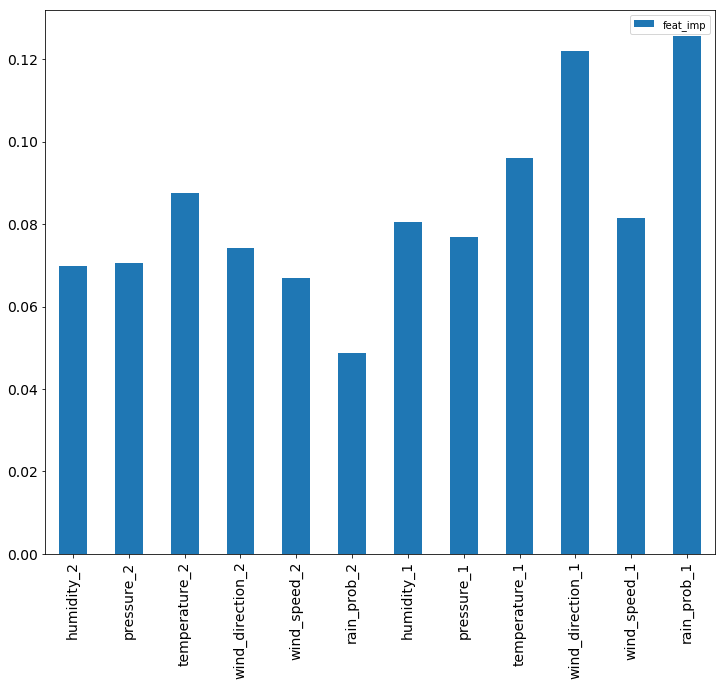

In [45]:
feat_imp = best_model.feature_importances_  # feature importances
feature_names = ['{}_{}'.format(i,win-j) for j in range(win) for i in train.columns if 'label' not in i]

feat_df = pd.DataFrame({'feat_imp':feat_imp}, index = feature_names)

ax = feat_df.plot.bar(figsize = (12,10),fontsize=14)
plt.rc('legend',fontsize=20)
a = plt.xticks(rotation=90)


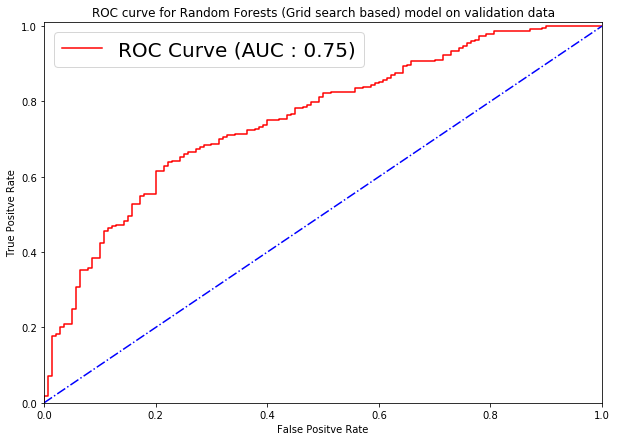

In [46]:
# Computing AUC and ROC curve for random forests model on validation data

# fp_rate_rf  : false positive rate for Random Forests  model
# tp_rate_rf  : true positive rate for Random Forests  model
# auc_rate_rf : AUC for Random Forests  model

fp_rate_rf,tp_rate_rf,_ = roc_curve(y_val,y_scorev[:,1]) # column 1 meets criteria where prob >= 0.5 corresponds to class-1
auc_val_rf = auc(fp_rate_rf,tp_rate_rf)
plt.figure(figsize=(10,7))

plt.plot(fp_rate_rf,tp_rate_rf,label='ROC Curve (AUC : {:.2f})'.format(auc_val_rf),color='red')
plt.plot([0, 1], [0, 1], color='blue', linestyle='-.')
plt.title('ROC curve for Random Forests (Grid search based) model on validation data')
plt.xlabel('False Positve Rate')
plt.ylabel('True Positve Rate')
plt.xlim([0, 1])
plt.ylim([0, 1.01])

plt.legend()
plt.show()